在本实例中，我们将加载Marmousi 1 Vp模型，指定源和接收器位置，然后使用Deepwave执行正演建模，通过模型传播源以生成合成接收器数据

首先，我们需要导入必要的包:

In [1]:
import torch
import matplotlib.pyplot as plt
import deepwave
from deepwave import scalar

然后我们选择我们希望在哪个设备上运行，指定模型的大小，并加载它:

我这里使用的是基于ARM64的macOS系统，所有只能选择cpu运行

In [2]:
# device = torch.device('cuda' if torch.cuda.is_available()
#                      else 'cpu')
device = torch.device('cpu')
ny = 2301
nx = 751
dx = 4.0
v = torch.from_file('marmousi_vp.bin',
                    size=ny*nx).reshape(ny, nx).to(device)

接下来，我们将指定震源和接收器的位置，以及震源子波。Deepwave可以同时传播多个震源。这纯粹是为了提高计算性能，而它们不会相互作用，结果应该是一样的，就好像这些震源是单独传播的一样。假设同时传播的震源具有相同数量的源和接收器，因此我们可以分别提供它们在维度为[shot, source, space]和 [shot, receiver, space]的张量中的位置，以及在维度为[shot, source, time]的张量中的源振幅。许多应用程序每次射击只有一个源，因此源尺寸将是单位长度，但Deepwave提供了更多选项:

In [3]:
# 总炮数
n_shots = 115

# 震源设置
n_sources_per_shot = 1
d_source = 20  # 20 * 4m = 80m
first_source = 10  # 10 * 4m = 40m
source_depth = 2  # 2 * 4m = 8m

# 接收器设置
n_receivers_per_shot = 384
d_receiver = 6  # 6 * 4m = 24m
first_receiver = 0  # 0 * 4m = 0m
receiver_depth = 2  # 2 * 4m = 8m

# 频率时间设置
freq = 25
nt = 750
dt = 0.004
peak_time = 1.5 / freq

# 震源位置
source_locations = torch.zeros(n_shots, n_sources_per_shot, 2,
                               dtype=torch.long, device=device)
source_locations[..., 1] = source_depth
source_locations[:, 0, 0] = (torch.arange(n_shots) * d_source +
                             first_source)

# 接收器位置
receiver_locations = torch.zeros(n_shots, n_receivers_per_shot, 2,
                                 dtype=torch.long, device=device)
receiver_locations[..., 1] = receiver_depth
receiver_locations[:, :, 0] = (
    (torch.arange(n_receivers_per_shot) * d_receiver +
     first_receiver)
    .repeat(n_shots, 1)
)

# 震源子波
source_amplitudes = (
    deepwave.wavelets.ricker(freq, nt, dt, peak_time)
    .repeat(n_shots, n_sources_per_shot, 1)
    .to(device)
)

这就是我们正演建模所需的所有设置，所以我们现在准备调用Deepwave。由于我们希望确保结果尽可能准确，我们将指定我们希望使用8阶精确空间有限差分:

In [4]:
out = scalar(v, dx, dt, source_amplitudes=source_amplitudes,
             source_locations=source_locations,
             receiver_locations=receiver_locations,
             accuracy=8,
             pml_freq=freq)

pml_freq参数是可选的，但推荐使用，因为它允许您指定PML的主频率，这有助于最小化边缘反射。你可以看到我们提供的源和接收张量也是可选的。你可以(或另外)为Deepwave提供初始波场来传播。

要传播的时间步长(以及输出接收器数据的长度)由源振幅的长度指定。如果传播时没有源项，则可以使用nt关键字参数指定它。

最后，我们将绘制生成数据的一个共炮点道集和一个共接受点道集，然后将数据保存到磁盘上，以便在后面的示例中使用:

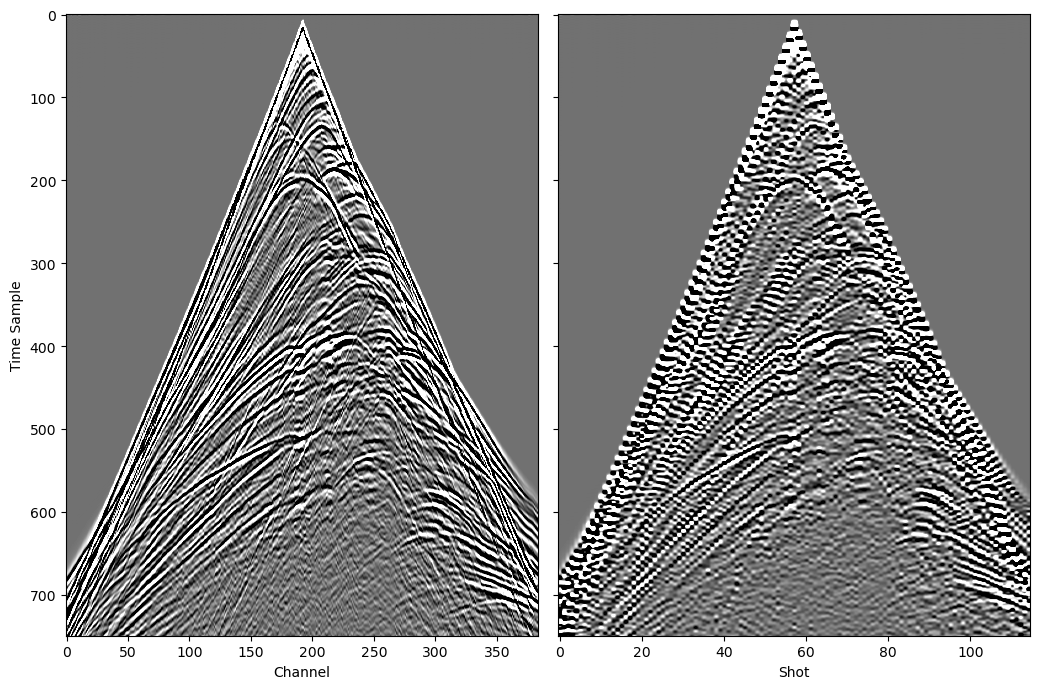

In [5]:
receiver_amplitudes = out[-1]
vmin, vmax = torch.quantile(receiver_amplitudes[0],
                            torch.tensor([0.05, 0.95]).to(device))
_, ax = plt.subplots(1, 2, figsize=(10.5, 7), sharey=True)
ax[0].imshow(receiver_amplitudes[57].cpu().T, aspect='auto',
             cmap='gray', vmin=vmin, vmax=vmax)
ax[1].imshow(receiver_amplitudes[:, 192].cpu().T, aspect='auto',
             cmap='gray', vmin=vmin, vmax=vmax)
ax[0].set_xlabel("Channel")
ax[0].set_ylabel("Time Sample")
ax[1].set_xlabel("Shot")
plt.tight_layout()

receiver_amplitudes.cpu().numpy().tofile('marmousi_data.bin')